In [1]:
import glob
import numpy as np
import os
import shutil
import PIL
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(42)

Using TensorFlow backend.


# 1 Data preprocessing

In [2]:
import copy
# Read all files from the fold 
_dataset_path = 'train/'
files = glob.glob(_dataset_path+"*")  #glob.glob is to extract the file into list

# save all cat images in cat_files

cat_files = []
dog_files = []

for f in files:
    fn = f.split('/')[-1].split('.')[0]
    if fn == 'cat':
        cat_files.append(f)
    elif fn == 'dog':
        dog_files.append(f)
    else:
        print("error:{}".format(f))

#cat_files = copy.deepcopy([fn for fn in files if 'cat' in fn])
#dog_files = copy.deepcopy([fn for fn in files if 'dog' in fn])

In [3]:
cat_files = np.array(cat_files)
dog_files = np.array(dog_files)

np.random.shuffle(cat_files)
np.random.shuffle(dog_files)

cat_train = cat_files[:1500]
cat_val = cat_files[1500:2000]
cat_test = cat_files[2000:2500]

dog_train = dog_files[:1500]
dog_val = dog_files[1500:2000]
dog_test = dog_files[2000:2500]
print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


### selecting sample randomly

In [4]:
# Create directories
def create_folder(_fold_path):
    try:
        os.makedirs(_fold_path)
    except OSError:
        print("***folder already exist***")

In [5]:
_asset_path = 'asset/dog_cat/'

#named the directory of data set
train_dir = _asset_path+'training_data/'
val_dir = _asset_path+'validation_data/'
test_dir = _asset_path+'test_data/'

create_folder(train_dir)
create_folder(val_dir)
create_folder(test_dir)

***folder already exist***
***folder already exist***
***folder already exist***


In [6]:
train_files = np.append(cat_train, dog_train)
validate_files = np.append(cat_val, dog_val)
test_files = np.append(cat_test, dog_test)

In [7]:
from shutil import copy2
def copy_to_dir(src_path, dst_path):
    for f in src_path:
        f_name = f.split("/")[-1]
        copy2(f,dst_path+f_name)
    print("sucess")     
    return

In [8]:
copy_to_dir(train_files, train_dir)
copy_to_dir(validate_files, val_dir)
copy_to_dir(test_files, test_dir)

sucess
sucess
sucess


# Expand the data with Augment

In [61]:
# the input shape
IMG_DIM = (150, 150)

# To extract the samples from directory of train
train_files = glob.glob(train_dir+"*") 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]

# To extract the samples from directory of val
validation_files = glob.glob(val_dir+'*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob(test_dir+'*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [63]:
from sklearn.preprocessing import LabelEncoder
# encode labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)
print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


### Rotate image,  Flip image, shear image, shift image

In [11]:
# To generate the sample from ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

# VGG model

# Description of layers:

![jupyter](https://cdn-images-1.medium.com/max/800/1*E7zhhan7Sp7hats4jkKdeA.png)

In [13]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [14]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


In [15]:
from keras.applications import vgg16
from keras.models import Model
import keras

# the VGG16 is pretrained model
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)
# the last layer
output = vgg.layers[-1].output # the out put of last layer
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False  # The layer is not trainable

for layer in vgg_model.layers:
    layer.trainable = False # each layer is not trainable

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [16]:
#To show the each layer whether can be trainable.
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7efcd9250240>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7efcd92507f0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7efcd9250668>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7efcd9272978>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7efcd92726a0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7efca83651d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7efca82fa6a0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7efca82fa518>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7efca82bb0f0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7efca82d20f0>,block3_conv3,False


(1, 4, 4, 512)


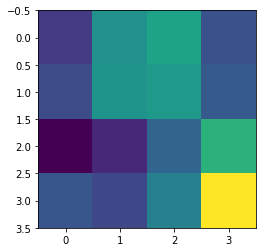

In [17]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [18]:
# the feature generated by the last layer of VGG16
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [19]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1948, 8192)


In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1] 

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [21]:
# To fit the model
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1948 samples
Epoch 1/30
3000/3000 [==============================] - 1s 487us/step - loss: 0.4578 - acc: 0.7743 - val_loss: 0.3152 - val_acc: 0.8522
Epoch 2/30
3000/3000 [==============================] - 1s 360us/step - loss: 0.3004 - acc: 0.8677 - val_loss: 0.2781 - val_acc: 0.8763
Epoch 3/30
3000/3000 [==============================] - 1s 351us/step - loss: 0.2446 - acc: 0.8953 - val_loss: 0.3687 - val_acc: 0.8491
Epoch 4/30
3000/3000 [==============================] - 1s 352us/step - loss: 0.2109 - acc: 0.9067 - val_loss: 0.2836 - val_acc: 0.8737
Epoch 5/30
3000/3000 [==============================] - 1s 358us/step - loss: 0.1693 - acc: 0.9320 - val_loss: 0.2951 - val_acc: 0.8773
Epoch 6/30
3000/3000 [==============================] - 1s 357us/step - loss: 0.1484 - acc: 0.9417 - val_loss: 0.3924 - val_acc: 0.8537
Epoch 7/30
3000/3000 [==============================] - 1s 353us/step - loss: 0.1248 - acc: 0.9533 - val_loss: 0.7319 - val_acc: 0.7993


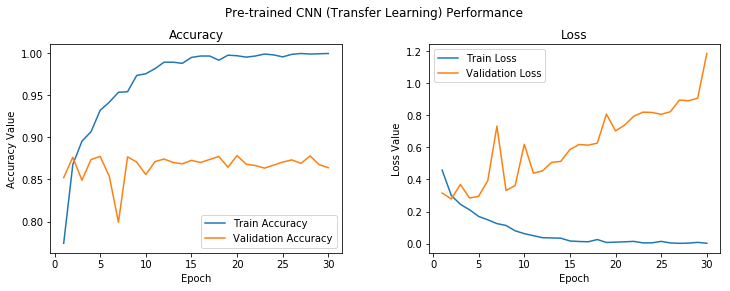

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

In [24]:

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [25]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
100/100 [==============================] - 23s 228ms/step - loss: 0.6696 - acc: 0.5873 - val_loss: 0.4819 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5819 - acc: 0.7017 - val_loss: 0.4102 - val_acc: 0.8350
Epoch 3/30
100/100 [==============================] - 19s 195ms/step - loss: 0.5160 - acc: 0.7543 - val_loss: 0.3409 - val_acc: 0.8440
Epoch 4/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4960 - acc: 0.7567 - val_loss: 0.3553 - val_acc: 0.8421
Epoch 5/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4700 - acc: 0.7697 - val_loss: 0.3106 - val_acc: 0.8630
Epoch 6/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4381 - acc: 0.7930 - val_loss: 0.2985 - val_acc: 0.8694
Epoch 7/30
100/100 [==============================] - 20s 199ms/step - loss: 0.4295 - acc: 0.7933 - val_loss: 0.2901 - val_acc: 0.8760
Epoch 8/30
100/100 [==============================] - 2

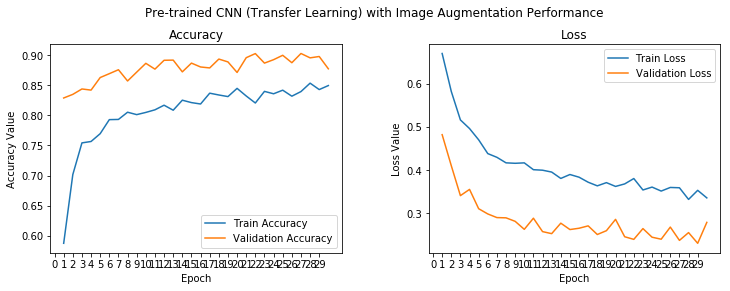

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 30, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [28]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [29]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block4_conv2/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block4_conv3/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32_ref>]


In [30]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7efcd9250240>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7efcd92507f0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7efcd9250668>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7efcd9272978>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7efcd92726a0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7efca83651d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7efca82fa6a0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7efca82fa518>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7efca82bb0f0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7efca82d20f0>,block3_conv3,False


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [32]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

In [34]:
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
30/30 [==============================] - 12s 406ms/step - loss: 0.4075 - acc: 0.8178 - val_loss: 0.2373 - val_acc: 0.9038
Epoch 2/30
30/30 [==============================] - 12s 404ms/step - loss: 0.3669 - acc: 0.8389 - val_loss: 0.2000 - val_acc: 0.9180
Epoch 3/30
30/30 [==============================] - 12s 403ms/step - loss: 0.3447 - acc: 0.8433 - val_loss: 0.2313 - val_acc: 0.8978
Epoch 4/30
30/30 [==============================] - 12s 406ms/step - loss: 0.3469 - acc: 0.8533 - val_loss: 0.2609 - val_acc: 0.8920
Epoch 5/30
30/30 [==============================] - 12s 405ms/step - loss: 0.3284 - acc: 0.8522 - val_loss: 0.1990 - val_acc: 0.9008
Epoch 6/30
30/30 [==============================] - 12s 409ms/step - loss: 0.3025 - acc: 0.8689 - val_loss: 0.1940 - val_acc: 0.9180
Epoch 7/30
30/30 [==============================] - 12s 411ms/step - loss: 0.3125 - acc: 0.8800 - val_loss: 0.2114 - val_acc: 0.9170
Epoch 8/30
30/30 [==============================] - 12s 413ms/step - 

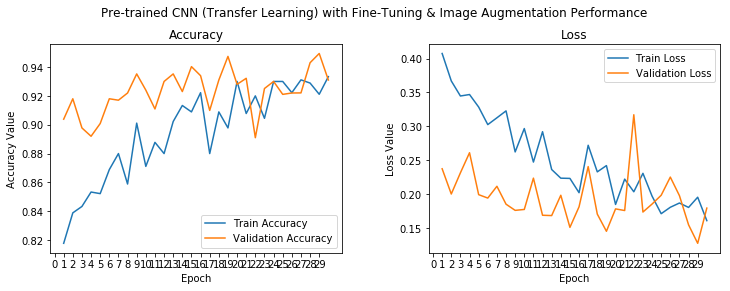

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 30, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Exercise 1 InceptionV3

![jupyter](https://cdn-images-1.medium.com/max/1200/1*gqKM5V-uo2sMFFPDS84yJw.png)

In [37]:
## 1 import used layers ##

############################
## Insert your code here ###
############################


In [38]:
## 2 Read data and Rescale data
############################
## Insert your code here ###
############################
# To extract the samples from directory of train



Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1948, 150, 150, 3)
['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


In [54]:
# image generator


In [55]:
train_imgs_scaled = train_imgs.astype('float32')

validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)



le = LabelEncoder()
le.fit(train_labels)
# encode  labels


['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


In [56]:
# pre-trained model inveptionV3


In [57]:
# def get_bottle_fatures



In [58]:
# get the pre-trained features from model


In [ ]:
# define the model


In [ ]:
# train the model


# Exercise 2 VGG19

![jupyter](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

In [76]:
## 1 import used layers ##

############################
## Insert your code here ###
############################

from keras.applications.vgg19 import VGG19

In [77]:
# def get_bottle_fatures
def get_bottle_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [81]:
#ImageDataGenerator


In [ ]:
## 2 Read data and Rescale data
############################
## Insert your code here ###
############################
# To extract the samples from directory of train


# encode  labels


In [82]:
train_imgs_scaled = train_imgs.astype('float32')

validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)


['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


In [83]:
# introduce VGG19 model


In [84]:
# get bottle feature

In [ ]:
# define our model


In [ ]:
# train the model


In [ ]:
#visulize
